In [4]:
# Dependencies
from modules.dataset.entities import Entities
from modules.dataset.tweets import Tweets
from langdetect import detect
import matplotlib.pyplot as plt
import pandas as pd
import json
import re

%matplotlib inline

In [18]:
# Paths
#TWEETS_RAW_PATH = 'data/tweets.jsonl'
TWEETS_DB_PATH = 'data/database/tweets.csv'
HASHTAGS_DB_PATH = 'data/database/entities.csv'
WORDS_DB_PATH = 'data/database/words.csv'
#SUBS_HASHTAGS_PATH = 'data/hashtag_subs.json'
SUBS_CONTRACT_PATH = 'data/contract_forms.json'

In [7]:
# Set network years
YEARS = [2017, 2018]

# Dataset creation

Once words and hashtags are extracted, they are stored in Pandas DataFrames with the following attributes:

1. <code> tweet_id </code> : Reference to the tweet ID
2. <code> entity_index </code> : Position of the word in the sentence (tweet) - useful to delete self loops 
3. <code> entity_text </code> : Text
4. <code> entity_tag </code> : Part Of Speech tag 
			

In [17]:
# Load Tweets dataset

# Initialize Tweets class
tweets = Tweets()
    
# Load tweets from disk
tweets = Tweets()
tweets.df = pd.read_csv(TWEETS_DB_PATH)[['created_at','id_str','text']]
tweets.df = tweets.df.rename(columns={'created_at':'tweet_date','id_str':'tweet_id','text':'tweet_text'})
print('BEFORE: ',tweets.df.shape)
is_english = tweets.df.tweet_text.apply(lambda x: detect(x) == 'en')
# Filter out dataset language
tweets.df = tweets.df[is_english]
print('AFTER: ',tweets.df.shape)
tweets.to_json('data/database/tweets.json')
tweets.df.head()

BEFORE:  (3026, 3)
AFTER:  (3013, 3)


,tweet_date,tweet_id,tweet_text
0,Sat Jun 30 22:35:06 +0000 2018,1013189209488797697,"#PrideMonth may be ending today, but we will c..."
1,Sat Jun 30 19:35:07 +0000 2018,1013143915308953606,“This disaster leaves us in extreme poverty......
2,Sat Jun 30 18:35:07 +0000 2018,1013128815575470081,We want more women on ballots 🗳️ when we go ou...
3,Sat Jun 30 16:35:09 +0000 2018,1013098625768009728,“The idea that sexism &amp; misogyny in online...
4,Sat Jun 30 15:05:12 +0000 2018,1013075989885341697,"When women are targeted online, the abuse is m..."


In [20]:
# Extract entities (i.e. hashtags and words)

# Load substitutions dictionary
subs = {}
# Load hahstag substitutions
#with open(SUBS_HASHTAGS_PATH, 'r') as file:
#    subs = {**subs, **json.load(file)}
# Load contact forms substitutions
with open(SUBS_CONTRACT_PATH, 'r') as file:
    subs = {**subs, **json.load(file)}

# Case dataset must be overwritten
# Retrieve hastags and words entities tables
hashtags, words = tweets.get_entities(subs=subs)
# Store entities tables to disk
hashtags.to_json(HASHTAGS_DB_PATH[:-3]+'json')
words.to_json(WORDS_DB_PATH[:-3]+'json')

In [21]:
# Show hashtags dataset header
hashtags.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
54734,847985662850723840,13,#childmarriage,#,0.3662
54720,848030929482285056,15,#HeForShe,#,0.9254
54682,848121534204039169,14,#stoptherobbery,#,0.9086
54640,848212148480356352,0,#ThanksForTyping,#,0.9217
54630,848257441942962181,10,#WomenofSyria,#,0.7413


In [22]:
# Show words dataset header
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
55628,847985662850723840,0,these,D,0.9818
55629,847985662850723840,1,teens,N,0.9962
55630,847985662850723840,2,in,P,0.9973
55631,847985662850723840,3,bangladesh,^,0.9847
55632,847985662850723840,4,are,V,0.9852


## Words filtering

In [23]:
# Recognize pronouns and clean from symbols
words.clean_entities()

In [24]:
# Automatically and manually found pronouns
words.df[words.df.entity_tag == 'O'].shape[0]

3517

In [25]:
# Manually found pronouns
words.df[(words.df.entity_conf == 1.0) & (words.df.entity_tag == 'O')].shape[0]

3501

In [26]:
# Filter on POS tag
words.df = words.df[words.df.entity_tag.isin(['N', 'V', 'R', 'A', 'O', 'S'])]
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
55629,847985662850723840,1,teen,N,0.9962
55633,847985662850723840,5,take,V,0.9994
55634,847985662850723840,6,it,O,1.0000
55636,847985662850723840,8,their,O,1.0000
55638,847985662850723840,10,hand,N,0.9960


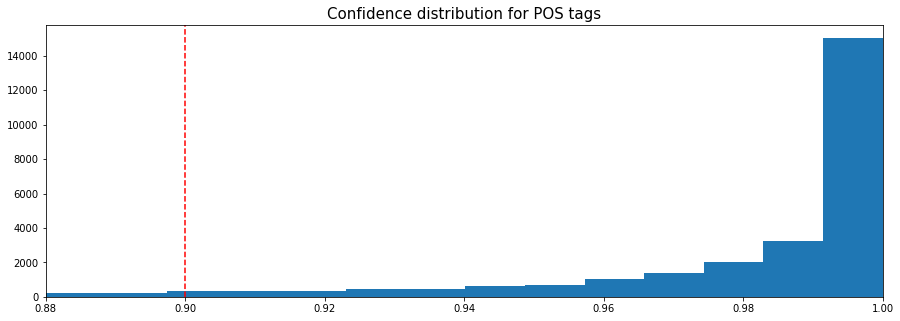

There are 5289 (17.03%) words under 0.90 confidence interval
There will be 25764 (82.97%) words remaining inside 0.90 confidence interval


In [27]:
# Set threshold on confidence
conf = 0.9

# Show confidence distribution
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Confidence distribution for POS tags',fontsize=15)
_ = ax.hist(words.df.entity_conf, bins=100)
_ = ax.set_xlim(left=0.88, right=1.0)
_ = ax.axvline(x=conf, c='r', ls='--')
# _ = plt.savefig('images/preprocessing/tag_conf.png')
_ = plt.show()

# info
print('There are {:d} ({:.02f}%) words under {:.2f} confidence interval'.format(
    sum(words.df.entity_conf < conf), sum(words.df.entity_conf < conf) / words.df.shape[0] * 100, conf
))
# info
print('There will be {:d} ({:.02f}%) words remaining inside {:.2f} confidence interval'.format(
    sum(words.df.entity_conf >= conf), sum(words.df.entity_conf >= conf) / words.df.shape[0] * 100, conf
))

In [28]:
# Filter on confidence
words.df = words.df[words.df.entity_conf >= conf]

In [29]:
# Number of pronouns after cleaning
words.df[words.df.entity_tag == 'O'].shape[0]

3501

In [30]:
# Total number of words extracted 
words.df.shape[0]

25764

In [31]:
words.to_json(WORDS_DB_PATH)

## Tweets filtering

In [32]:
# Make a copy of tweets dataset
filtered = Tweets()
filtered.df = tweets.df.copy()

In [33]:
# Filter out \r and \n characters from tweets

# Get tweet text
tweet_text = filtered.df.tweet_text
# Filter out \t, \r and \n characters from tweets
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[\t\n\r]+', ' ', txt))
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[ ]+', ' ', txt))
# Save dataset to disk
filtered.df.tweet_text = tweet_text
filtered.to_tsv('data/db/tweets_filtered_1.csv')
filtered.df.head(20)

FileNotFoundError: [Errno 2] No such file or directory: 'data/db/tweets_filtered_1.csv'

In [20]:
# Filter out non ascii symbols (e.g. emoticons)

tweet_text = tweet_text.apply(lambda txt: re.sub(r'[^\x00-\x7F]+',' ', txt))
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[ ]+', ' ', txt))

filtered.df.tweet_text = tweet_text
filtered.to_tsv('data/db/tweets_filtered_2.csv')
filtered.df.head(20)

,tweet_id,tweet_date,tweet_text
0,836950901495631872,2017-03-01 14:46:59,TT SINGAPORE 22:46 1.Hong Kong 2.#JointAddress...
1,836950882528989184,2017-03-01 14:46:54,Letting #snapchat prepare me for the day's uns...
2,836950869639835649,2017-03-01 14:46:51,"""The bill would require the state to get all o..."
3,836950847380668416,2017-03-01 14:46:46,Style-Lead don't Follow #recycledfashion https...
4,836950839101116421,2017-03-01 14:46:44,Shell knew : oil giant's 1991 film warned of ...
5,836950831958224896,2017-03-01 14:46:42,Mythbusting #climate fact: Current Arctic sea ...
6,836950753520427008,2017-03-01 14:46:24,A revolution is required in the way we think a...
7,836950737502494720,2017-03-01 14:46:20,https://t.co/7sDZTyB9hD States need environmen...
8,836950728967081984,2017-03-01 14:46:18,With environmental &amp; social impact less sc...
9,836950727599788035,2017-03-01 14:46:17,so what does solar radiation management look l...


In [21]:
# Filter out everything that is not alphanumeric

tweet_text = tweet_text.apply(lambda txt: re.sub(r'[^a-zA-Z0-9\-\,\.\!\?\"\'\;\:\_]+',' ', txt))
tweet_text = tweet_text.apply(lambda txt: re.sub(r'[ ]+', ' ', txt))

filtered.df.tweet_text = tweet_text
filtered.to_tsv('data/db/tweets_filtered_3.csv')
filtered.df.head(20)

,tweet_id,tweet_date,tweet_text
0,836950901495631872,2017-03-01 14:46:59,TT SINGAPORE 22:46 1.Hong Kong 2. JointAddress...
1,836950882528989184,2017-03-01 14:46:54,Letting snapchat prepare me for the day's unse...
2,836950869639835649,2017-03-01 14:46:51,"""The bill would require the state to get all o..."
3,836950847380668416,2017-03-01 14:46:46,Style-Lead don't Follow recycledfashion https:...
4,836950839101116421,2017-03-01 14:46:44,Shell knew : oil giant's 1991 film warned of ...
5,836950831958224896,2017-03-01 14:46:42,Mythbusting climate fact: Current Arctic sea i...
6,836950753520427008,2017-03-01 14:46:24,A revolution is required in the way we think a...
7,836950737502494720,2017-03-01 14:46:20,https: t.co 7sDZTyB9hD States need environment...
8,836950728967081984,2017-03-01 14:46:18,With environmental amp; social impact less scr...
9,836950727599788035,2017-03-01 14:46:17,so what does solar radiation management look l...
